In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%cd ..

/scratch/km817/iREC


In [4]:
import torch
import hamiltorch
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F

In [5]:
%matplotlib inline

In [6]:
hamiltorch.set_random_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
hamiltorch.__version__

'0.4.0.dev1'

In [8]:
from models.BNNs.DeterministicNN import Deterministic_NN

In [9]:
fs=16
# create toy dataset
torch.set_default_tensor_type(torch.DoubleTensor)
torch.manual_seed(20)
x = torch.cat([torch.Tensor(75).uniform_(-5, -2).sort()[0].reshape(-1, 1),
               torch.Tensor(50).uniform_(2, 5).sort()[0].reshape(-1, 1)])
i = 30
x_data = torch.cat([x[0:i - 15], x[i + 14:]])

# generate some data
alpha, beta, num_nodes = 1., 100., 2

# generate some data
data_generator_model = Deterministic_NN(alpha=alpha, beta=beta, num_nodes=num_nodes)
sampled_weights = data_generator_model.sample_weights_from_prior()
data_generator_model.make_weights_from_sample(sampled_weights)
y_data = data_generator_model(x_data).detach() + (
            1 / data_generator_model.likelihood_beta ** 0.5) * torch.randn_like(
    data_generator_model(x_data).detach())

xs = torch.linspace(-10, 10, 100)
ys = data_generator_model(xs).detach()

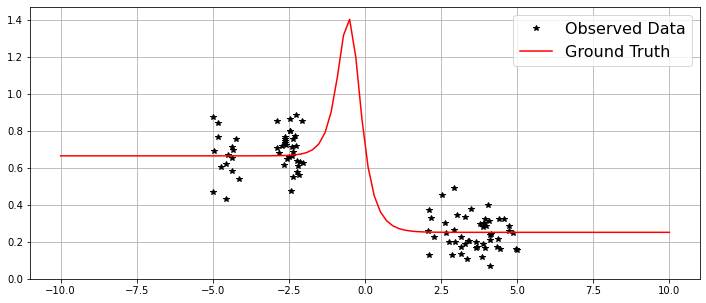

In [10]:
plt.figure(figsize=(12,5))
plt.plot(x_data,y_data, 'k*')
plt.plot(xs, ys, 'r')
plt.legend(['Observed Data', 'Ground Truth'], fontsize = fs)
plt.grid()
plt.show()

In [11]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# if torch.cuda.is_available():
#     print(torch.cuda.get_device_name(0))

device  =torch.device('cpu')
class Net(nn.Module):
    def __init__(self, num_nodes: int = 10):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, num_nodes)
        self.fc2 = nn.Linear(num_nodes, num_nodes)
        self.fc3 = nn.Linear(num_nodes, 1)

    def forward(self, x):
        x = torch.tanh(self.fc1(x.view(-1, 1)))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net(num_nodes=num_nodes)

In [12]:
step_size = 0.005
num_samples = 10000
L = 10
burn = 3000
store_on_GPU = False
debug = False
model_loss = 'regression'
mass = 1.0

# Effect of tau
# Set to tau = 1000. to see a function that is less bendy (weights restricted to small bends)
# Set to tau = 1. for more flexible

tau = alpha # Prior Precision
tau_out = beta # Output Precision
r = 0 # Random seed


tau_list = []
for w in net.parameters():
    tau_list.append(tau) # set the prior precision to be the same for each set of weights
tau_list = torch.tensor(tau_list).to(device)

# Set initial weights
params_init = hamiltorch.util.flatten(net).to(device).clone()
# Set the Inverse of the Mass matrix
inv_mass = torch.ones(params_init.shape) / mass

In [13]:
print(params_init.shape)
integrator = hamiltorch.Integrator.EXPLICIT
sampler = hamiltorch.Sampler.HMC

hamiltorch.set_random_seed(r)
params_hmc_f = hamiltorch.sample_model(net, x_data.to(device), y_data.to(device), params_init=params_init,
                                       model_loss=model_loss, num_samples=num_samples,
                                       burn = burn, inv_mass=inv_mass.to(device),step_size=step_size,
                                       num_steps_per_sample=L,tau_out=tau_out, tau_list=tau_list,
                                       debug=debug, store_on_GPU=store_on_GPU,
                                       sampler = sampler)

# At the moment, params_hmc_f is on the CPU so we move to GPU

params_hmc_gpu = [ll.to(device) for ll in params_hmc_f[1:]]


# Let's predict over the entire test range [-2,2]
pred_list, log_probs_f = hamiltorch.predict_model(net, x = xs.to(device),
                                                  y = xs.to(device), samples=params_hmc_gpu,
                                                  model_loss=model_loss, tau_out=tau_out,
                                                  tau_list=tau_list)
# Let's evaluate the performance over the training data
pred_list_tr, log_probs_split_tr = hamiltorch.predict_model(net, x = x_data.to(device), y=y_data.to(device),
                                                            samples=params_hmc_gpu, model_loss=model_loss,
                                                            tau_out=tau_out, tau_list=tau_list)
ll_full = torch.zeros(pred_list_tr.shape[0])
ll_full[0] = - 0.5 * tau_out * ((pred_list_tr[0].cpu() - y_data) ** 2).sum(0)
for i in range(pred_list_tr.shape[0]):
    ll_full[i] = - 0.5 * tau_out * ((pred_list_tr[:i].mean(0).cpu() - y_data) ** 2).sum(0)

torch.Size([13])
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples     | Samples/sec
0d:00:02:19 | 0d:00:00:00 | #################### | 10000/10000 | 71.60       
Acceptance Rate 0.96


In [14]:
ll_full = torch.zeros(pred_list_tr.shape[0])
ll_full[0] = - 0.5 * tau_out * ((pred_list_tr[0].cpu() - y_data) ** 2).sum(0)
for i in range(pred_list_tr.shape[0]):
    ll_full[i] = - 0.5 * tau_out * ((pred_list_tr[:i].mean(0).cpu() - y_data) ** 2).sum(0)

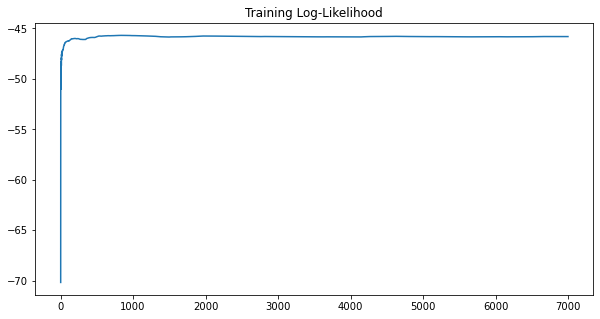

In [15]:
f, ax1 = plt.subplots(1,1, figsize = (10,5))
ax1.set_title('Training Log-Likelihood')
ax1.plot(ll_full)

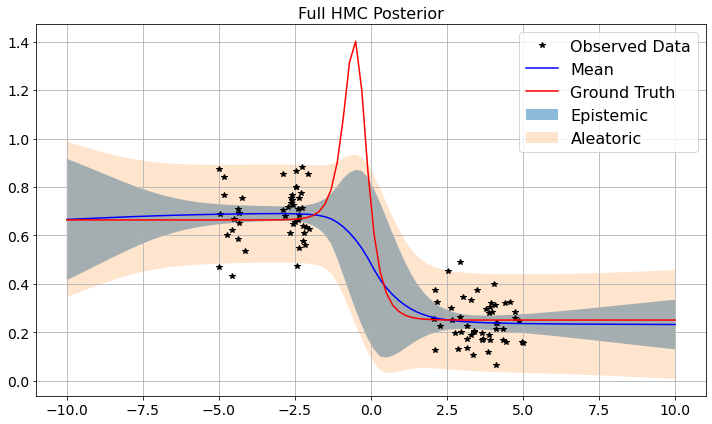

In [16]:
fs = 16

m = pred_list[2000:].mean(0).to('cpu')
s = pred_list[2000:].std(0).to('cpu')
s_al = (pred_list[2000:].var(0).to('cpu') + tau_out ** -1) ** 0.5

f, ax = plt.subplots(1, 1, figsize=(10, 6))

# Get upper and lower confidence bounds
lower, upper = (m - s*2).flatten(), (m + s*2).flatten()
# + aleotoric
lower_al, upper_al = (m - s_al*2).flatten(), (m + s_al*2).flatten()

# Plot training data as black stars
ax.plot(x_data.numpy(), y_data.numpy(), 'k*', rasterized=True)
# Plot predictive means as blue line
ax.plot(xs.numpy(), m.numpy(), 'b', rasterized=True)
ax.plot(xs.numpy(), ys.numpy(), 'r', rasterized=True)
# Shade between the lower and upper confidence bounds
ax.fill_between(xs.flatten().numpy(), lower.numpy(), upper.numpy(), alpha=0.5, rasterized=True)
ax.fill_between(xs.flatten().numpy(), lower_al.numpy(), upper_al.numpy(), alpha=0.2, rasterized=True)
plt.grid()
ax.legend(['Observed Data', 'Mean', 'Ground Truth', 'Epistemic', 'Aleatoric'], fontsize = fs)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
ax.set_title('Full HMC Posterior', fontsize=fs)

plt.tight_layout()
# plt.savefig('plots/full_hmc.pdf', rasterized=True)
    
plt.show()


# Draw subset of samples

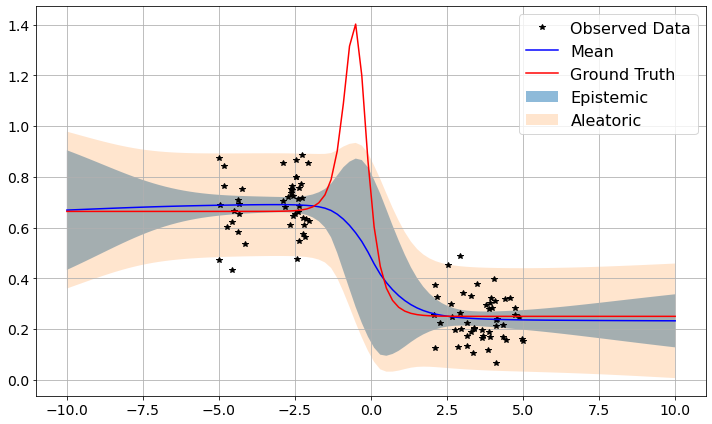

In [20]:
import random

subset = random.sample(params_hmc_gpu[2000:], 2500)
# Let's predict over the entire test range [-2,2]
pred_list, log_probs_f = hamiltorch.predict_model(net, x = xs.to(device),
                                                  y = xs.to(device), samples=subset,
                                                  model_loss=model_loss, tau_out=tau_out,
                                                  tau_list=tau_list)

# plot the fit
fs = 16

m = pred_list.mean(0).to('cpu')
s = pred_list.std(0).to('cpu')
s_al = (pred_list.var(0).to('cpu') + tau_out ** -1) ** 0.5

f, ax = plt.subplots(1, 1, figsize=(10, 6))

# Get upper and lower confidence bounds
lower, upper = (m - s*2).flatten(), (m + s*2).flatten()
# + aleotoric
lower_al, upper_al = (m - s_al*2).flatten(), (m + s_al*2).flatten()

# Plot training data as black stars
ax.plot(x_data.numpy(), y_data.numpy(), 'k*', rasterized=True)
# Plot predictive means as blue line
ax.plot(xs.numpy(), m.numpy(), 'b', rasterized=True)
ax.plot(xs.numpy(), ys.numpy(), 'r', rasterized=True)
# Shade between the lower and upper confidence bounds
ax.fill_between(xs.flatten().numpy(), lower.numpy(), upper.numpy(), alpha=0.5, rasterized=True)
ax.fill_between(xs.flatten().numpy(), lower_al.numpy(), upper_al.numpy(), alpha=0.2, rasterized=True)
plt.grid()
ax.legend(['Observed Data', 'Mean', 'Ground Truth', 'Epistemic', 'Aleatoric'], fontsize = fs)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)


plt.tight_layout()
# plt.savefig('plots/full_hmc.pdf', rasterized=True)
    
plt.show()

In [21]:
#lets compress some samples
#### sample weights with compression algorithm
from tqdm.notebook import trange
from rec.beamsearch.Coders.Encoder_Empirical import Encoder
from rec.beamsearch.distributions.CodingSampler import CodingSampler
from rec.beamsearch.distributions.EmpiricalMixturePosterior import EmpiricalMixturePosterior
from rec.beamsearch.samplers.GreedySampling_BNNs import GreedySampler
from models.BNNs.BNN_for_HMC import BNN_for_HMC
import pyro.distributions as dist

In [22]:
dummy_model = BNN_for_HMC(alpha=alpha, beta=beta, num_nodes=num_nodes)

In [23]:
emp_samples = torch.empty([0])
for s in subset:
    emp_samples = torch.cat([emp_samples, s[None]])

In [24]:
emp_dist = dist.Empirical(emp_samples, log_weights=torch.ones(emp_samples.shape[0]))

In [25]:
from rec.OptimisingVars.FinalJointOptimiser import FinalJointOptimiser
coding_sampler = CodingSampler
auxiliary_posterior = EmpiricalMixturePosterior
selection_sampler = GreedySampler
omega = 5
kl_q_p = 20
initial_seed = 0
beamwidth = 5
epsilon = 0.2
dummy_encoder = Encoder(dummy_model,
                     x_data,
                     y_data,
                     emp_samples,
                     initial_seed,
                     coding_sampler,
                     selection_sampler,
                     auxiliary_posterior,
                     omega,
                     beamwidth,
                     epsilon=epsilon,
                     prior_var=1./alpha,
                     total_kl=kl_q_p)

z_sample = emp_dist.mean
omega = 5
n_trajectories = 64
n_auxiliaries = dummy_encoder.n_auxiliary
prior_var = 1./alpha
emp_opt = FinalJointOptimiser(z_sample, omega, n_auxiliaries, kl_q_p, n_trajectories, prior_var)
aux_vars = emp_opt.run_optimiser(epochs=10000)

/scratch/km817/miniconda3/envs/Torch/lib/python3.8/site-packages/pyro/distributions/torch_patch.py:81: UserWarning: torch.symeig is deprecated in favor of torch.linalg.eigh and will be removed in a future PyTorch release.
The default behavior has changed from using the upper triangular portion of the matrix by default to using the lower triangular portion.
L, _ = torch.symeig(A, upper=upper)
should be replaced with
L = torch.linalg.eigvalsh(A, UPLO='U' if upper else 'L')
and
L, V = torch.symeig(A, eigenvectors=True)
should be replaced with
L, V = torch.linalg.eigh(A, UPLO='U' if upper else 'L') (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2500.)
  return torch.stack([v.symeig(eigenvectors=False)[0][:1] > 0.0
The mean loss is 7.70913. The mean KL is: 6.39233: 100%|██████████| 10000/10000 [02:18<00:00, 72.08it/s]


In [ ]:
coding_sampler = CodingSampler
auxiliary_posterior = EmpiricalMixturePosterior
selection_sampler = GreedySampler
omega = 5

initial_seed = 0
beamwidth = 20
epsilon = 0.3
num_compressed_samples = 250
compressed_weights = []

for i in trange(num_compressed_samples):
    initial_seed = initial_seed + i * 10
    encoder = Encoder(dummy_model,
                     x_data,
                     y_data,
                     emp_samples,
                     initial_seed,
                     coding_sampler,
                     selection_sampler,
                     auxiliary_posterior,
                     omega,
                     beamwidth,
                     epsilon=epsilon,
                     prior_var=1./alpha,
                     total_kl=kl_q_p)
    
    encoder.auxiliary_posterior.coding_sampler.auxiliary_vars = aux_vars
    
    w, idx = encoder.run_encoder()

    compressed_weights.append(w[0])

  0%|          | 0/250 [00:00<?, ?it/s]

/scratch/km817/miniconda3/envs/Torch/lib/python3.8/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


In [ ]:
encoder.n_samples_from_target

In [ ]:
pred_list, log_probs_f = hamiltorch.predict_model(net, x = xs.to(device),
                                                  y = xs.to(device), samples=compressed_weights,
                                                  model_loss=model_loss, tau_out=tau_out,
                                                  tau_list=tau_list)

# plot the fit
fs = 16

m = pred_list.mean(0).to('cpu')
s = pred_list.std(0).to('cpu')
s_al = (pred_list.var(0).to('cpu') + tau_out ** -1) ** 0.5

f, ax = plt.subplots(1, 1, figsize=(10, 6))

# Get upper and lower confidence bounds
lower, upper = (m - s*2).flatten(), (m + s*2).flatten()
# + aleotoric
lower_al, upper_al = (m - s_al*2).flatten(), (m + s_al*2).flatten()

# Plot training data as black stars
ax.plot(x_data.numpy(), y_data.numpy(), 'k*', rasterized=True)
# Plot predictive means as blue line
ax.plot(xs.numpy(), m.numpy(), 'b', rasterized=True)
ax.plot(xs.numpy(), ys.numpy(), 'r', rasterized=True)# Shade between the lower and upper confidence bounds
ax.fill_between(xs.flatten().numpy(), lower.numpy(), upper.numpy(), alpha=0.5, rasterized=True)
ax.fill_between(xs.flatten().numpy(), lower_al.numpy(), upper_al.numpy(), alpha=0.2, rasterized=True)
plt.grid()
ax.legend(['Observed Data', 'Mean', 'Ground Truth', 'Epistemic', 'Aleatoric'], fontsize = fs)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
ax.set_title('Compressed Empirical Posterior, BW=5, Epsilon=0.', fontsize=fs)

plt.tight_layout()
# plt.savefig('plots/full_hmc.pdf', rasterized=True)
    
plt.show()

In [ ]:
coding_sampler = CodingSampler
auxiliary_posterior = EmpiricalMixturePosterior
selection_sampler = GreedySampler
omega = 5

initial_seed = 0
beamwidth = 5
epsilon = 0.2
num_compressed_samples = 50
compressed_weights = []

for i in trange(num_compressed_samples):
    initial_seed = initial_seed + i * 10
    encoder = Encoder(dummy_model,
                     x_data,
                     y_data,
                     emp_samples,
                     initial_seed,
                     coding_sampler,
                     selection_sampler,
                     auxiliary_posterior,
                     omega,
                     beamwidth,
                     epsilon=epsilon,
                     prior_var=1./alpha,
                     total_kl=kl_q_p)
    
    encoder.auxiliary_posterior.coding_sampler.auxiliary_vars = aux_vars
    
    w, idx = encoder.run_encoder()

    compressed_weights.append(w[0])

In [ ]:
pred_list, log_probs_f = hamiltorch.predict_model(net, x = xs.to(device),
                                                  y = xs.to(device), samples=compressed_weights,
                                                  model_loss=model_loss, tau_out=tau_out,
                                                  tau_list=tau_list)

# plot the fit
fs = 16

m = pred_list.mean(0).to('cpu')
s = pred_list.std(0).to('cpu')
s_al = (pred_list.var(0).to('cpu') + tau_out ** -1) ** 0.5

f, ax = plt.subplots(1, 1, figsize=(10, 6))

# Get upper and lower confidence bounds
lower, upper = (m - s*2).flatten(), (m + s*2).flatten()
# + aleotoric
lower_al, upper_al = (m - s_al*2).flatten(), (m + s_al*2).flatten()

# Plot training data as black stars
ax.plot(x_data.numpy(), y_data.numpy(), 'k*', rasterized=True)
# Plot predictive means as blue line
ax.plot(xs.numpy(), m.numpy(), 'b', rasterized=True)
ax.plot(xs.numpy(), ys.numpy(), 'r', rasterized=True)# Shade between the lower and upper confidence bounds
ax.fill_between(xs.flatten().numpy(), lower.numpy(), upper.numpy(), alpha=0.5, rasterized=True)
ax.fill_between(xs.flatten().numpy(), lower_al.numpy(), upper_al.numpy(), alpha=0.2, rasterized=True)
plt.grid()
ax.legend(['Observed Data', 'Mean', 'Ground Truth', 'Epistemic', 'Aleatoric'], fontsize = fs)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
ax.set_title('Compressed Empirical Posterior, BW=1, Epsilon=0.', fontsize=fs)

plt.tight_layout()
# plt.savefig('plots/full_hmc.pdf', rasterized=True)
    
plt.show()

In [ ]:
coding_sampler = CodingSampler
auxiliary_posterior = EmpiricalMixturePosterior
selection_sampler = GreedySampler
omega = 5

initial_seed = 0
beamwidth = 5
epsilon = 0.2
num_compressed_samples = 50
compressed_weights = []

for i in trange(num_compressed_samples):
    initial_seed = initial_seed + i * 10
    encoder = Encoder(dummy_model,
                     x_data,
                     y_data,
                     emp_samples,
                     initial_seed,
                     coding_sampler,
                     selection_sampler,
                     auxiliary_posterior,
                     omega,
                     beamwidth,
                     epsilon=epsilon,
                     prior_var=1./alpha,
                     total_kl=kl_q_p)
    
    encoder.auxiliary_posterior.coding_sampler.auxiliary_vars = aux_vars
    
    w, idx = encoder.run_encoder()

    compressed_weights.append(w[0])

In [ ]:
pred_list, log_probs_f = hamiltorch.predict_model(net, x = xs.to(device),
                                                  y = xs.to(device), samples=compressed_weights,
                                                  model_loss=model_loss, tau_out=tau_out,
                                                  tau_list=tau_list)

# plot the fit
fs = 16

m = pred_list.mean(0).to('cpu')
s = pred_list.std(0).to('cpu')
s_al = (pred_list.var(0).to('cpu') + tau_out ** -1) ** 0.5

f, ax = plt.subplots(1, 1, figsize=(10, 6))

# Get upper and lower confidence bounds
lower, upper = (m - s*2).flatten(), (m + s*2).flatten()
# + aleotoric
lower_al, upper_al = (m - s_al*2).flatten(), (m + s_al*2).flatten()

# Plot training data as black stars
ax.plot(x_data.numpy(), y_data.numpy(), 'k*', rasterized=True)
# Plot predictive means as blue line
ax.plot(xs.numpy(), m.numpy(), 'b', rasterized=True)
ax.plot(xs.numpy(), ys.numpy(), 'r', rasterized=True)# Shade between the lower and upper confidence bounds
ax.fill_between(xs.flatten().numpy(), lower.numpy(), upper.numpy(), alpha=0.5, rasterized=True)
ax.fill_between(xs.flatten().numpy(), lower_al.numpy(), upper_al.numpy(), alpha=0.2, rasterized=True)
plt.grid()
ax.legend(['Observed Data', 'Mean', 'Ground Truth', 'Epistemic', 'Aleatoric'], fontsize = fs)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
ax.set_title('Compressed Empirical Posterior, BW=5, Epsilon=0.2', fontsize=fs)

plt.tight_layout()
# plt.savefig('plots/full_hmc.pdf', rasterized=True)
    
plt.show()

# thinning the samples

In [ ]:
coding_sampler = CodingSampler
auxiliary_posterior = EmpiricalMixturePosterior
selection_sampler = GreedySampler
omega = 5

initial_seed = 0
beamwidth = 5
epsilon = 0.
num_compressed_samples = 50
compressed_weights = []

for i in trange(num_compressed_samples):
    initial_seed = initial_seed + i * 10
    encoder = Encoder(dummy_model,
                     x_data,
                     y_data,
                     emp_samples,
                     initial_seed,
                     coding_sampler,
                     selection_sampler,
                     auxiliary_posterior,
                     omega,
                     beamwidth,
                     epsilon=epsilon,
                     prior_var=1./alpha,
                     total_kl=200.)
    
    #encoder.auxiliary_posterior.coding_sampler.auxiliary_vars = aux_vars
    
    w, idx = encoder.run_encoder()

    compressed_weights.append(w[0])

In [ ]:
pred_list, log_probs_f = hamiltorch.predict_model(net, x = xs.to(device),
                                                  y = xs.to(device), samples=compressed_weights,
                                                  model_loss=model_loss, tau_out=tau_out,
                                                  tau_list=tau_list)

# plot the fit
fs = 16

m = pred_list.mean(0).to('cpu')
s = pred_list.std(0).to('cpu')
s_al = (pred_list.var(0).to('cpu') + tau_out ** -1) ** 0.5

f, ax = plt.subplots(1, 1, figsize=(10, 6))

# Get upper and lower confidence bounds
lower, upper = (m - s*2).flatten(), (m + s*2).flatten()
# + aleotoric
lower_al, upper_al = (m - s_al*2).flatten(), (m + s_al*2).flatten()

# Plot training data as black stars
ax.plot(x_data.numpy(), y_data.numpy(), 'k*', rasterized=True)
# Plot predictive means as blue line
ax.plot(xs.numpy(), m.numpy(), 'b', rasterized=True)
ax.plot(xs.numpy(), ys.numpy(), 'r', rasterized=True)# Shade between the lower and upper confidence bounds
ax.fill_between(xs.flatten().numpy(), lower.numpy(), upper.numpy(), alpha=0.5, rasterized=True)
ax.fill_between(xs.flatten().numpy(), lower_al.numpy(), upper_al.numpy(), alpha=0.2, rasterized=True)
plt.grid()
ax.legend(['Observed Data', 'Mean', 'Ground Truth', 'Epistemic', 'Aleatoric'], fontsize = fs)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
ax.set_title('Compressed Empirical Posterior, BW=5, Epsilon=0.', fontsize=fs)

plt.tight_layout()
# plt.savefig('plots/full_hmc.pdf', rasterized=True)
    
plt.show()

In [ ]:
log_probs = torch.empty([0])
for w in compressed_weights:
    #make model
    dummy_model.make_weights_from_sample(w)
    log_probs = torch.cat([log_probs, dummy_model.joint_log_prob(x_data, y_data)[None]])

In [ ]:
log_probs

In [ ]:
vals, idxs = torch.topk(log_probs, 1)

In [ ]:
thinned_weights = []
for i in idxs:
    j = int(i)
    thinned_weights.append(compressed_weights[j])

In [ ]:
pred_list, log_probs_f = hamiltorch.predict_model(net, x = xs.to(device),
                                                  y = xs.to(device), samples=thinned_weights,
                                                  model_loss=model_loss, tau_out=tau_out,
                                                  tau_list=tau_list)

# plot the fit
fs = 16

m = pred_list.mean(0).to('cpu')
s = pred_list.std(0).to('cpu')
s_al = (pred_list.var(0).to('cpu') + tau_out ** -1) ** 0.5

f, ax = plt.subplots(1, 1, figsize=(10, 6))

# Get upper and lower confidence bounds
lower, upper = (m - s*2).flatten(), (m + s*2).flatten()
# + aleotoric
lower_al, upper_al = (m - s_al*2).flatten(), (m + s_al*2).flatten()

# Plot training data as black stars
ax.plot(x_data.numpy(), y_data.numpy(), 'k*', rasterized=True)
# Plot predictive means as blue line
ax.plot(xs.numpy(), m.numpy(), 'b', rasterized=True)
ax.plot(xs.numpy(), ys.numpy(), 'r', rasterized=True)# Shade between the lower and upper confidence bounds
ax.fill_between(xs.flatten().numpy(), lower.numpy(), upper.numpy(), alpha=0.5, rasterized=True)
ax.fill_between(xs.flatten().numpy(), lower_al.numpy(), upper_al.numpy(), alpha=0.2, rasterized=True)
plt.grid()
ax.legend(['Observed Data', 'Mean', 'Ground Truth', 'Epistemic', 'Aleatoric'], fontsize = fs)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
ax.set_title('Compressed Empirical Posterior, BW=5, Epsilon=0., big kl', fontsize=fs)

plt.tight_layout()
# plt.savefig('plots/full_hmc.pdf', rasterized=True)
    
plt.show()

# How to compute KL(p(W|D)||p(W))

In [ ]:
# define placeholder model
dummy_model = BNN_for_HMC(alpha=alpha, beta=beta, num_nodes=num_nodes)
compressed_weights = []
num_compressed_samples = 2

emp_samples = torch.empty([0])
for s in params_hmc_gpu[1000:]:
    emp_samples = torch.cat([emp_samples, s[None]])

In [ ]:
emp_samples = torch.empty([0])
for s in params_hmc_gpu:
    emp_samples = torch.cat([emp_samples, s[None]])

In [ ]:
problem_dimension = emp_samples.shape[-1]
empirical_samples = emp_samples
# create dummy coding object to compute kl with target
coding_z_prior = coding_sampler(problem_dimension=problem_dimension, n_auxiliary=1, var=(1./alpha))

# for each empirical sample, compute MC KL estimate
# first need to compute estimate of KL with joint
likelihoods = torch.empty([0])
for sample in empirical_samples:
    # make a model
    dummy_model.make_weights_from_sample(sample)

    likelihood = dummy_model.data_likelihood(x_data, y_data)
    likelihoods = torch.cat([likelihoods, likelihood[None]])

kl_term_1 = likelihoods.mean()

# to work out second KL term p(D) need to sample from prior and measure likelihood
n_samples = 10000
prior_samples = coding_z_prior.sample((n_samples,))
log_marginal_data = torch.zeros([0])
for sample in prior_samples:
    # make a model
    dummy_model.make_weights_from_sample(sample)

    log_marginal = dummy_model.data_likelihood(x_data, y_data)
    log_marginal_data = torch.cat([log_marginal_data, log_marginal[None]])

kl_term_2 = - torch.log(torch.tensor(n_samples)) + torch.logsumexp(log_marginal_data, dim=0)


total_kl = kl_term_1 - kl_term_2
print(total_kl)

In [ ]:
# to work out second KL term p(D) need to sample from prior and measure likelihood
n_samples = 10000
prior_samples = coding_z_prior.sample((n_samples,))
log_marginal_data = torch.zeros([0])
for sample in prior_samples:
    # make a model
    dummy_model.make_weights_from_sample(sample)

    log_marginal = dummy_model.data_likelihood(x_data, y_data)
    log_marginal_data = torch.cat([log_marginal_data, log_marginal[None]])

kl_term_2 = - torch.log(torch.tensor(n_samples)) + torch.logsumexp(log_marginal_data, dim=0)

In [ ]:
kl_term_1

In [ ]:
- kl_term_2

In [ ]:
dummy_model.data_likelihood(x_data, y_data)

In [ ]:
likelihoods = torch.empty([0])
for sample in empirical_samples:
    # make a model
    dummy_model.make_weights_from_sample(sample)

    likelihood = dummy_model.data_likelihood(x_data, y_data)
    likelihoods = torch.cat([likelihoods, likelihood[None]])

kl_term_1 = likelihoods.mean()

In [ ]:
dummy_model.data_likelihood(x_data, y_data)

In [ ]:
log_probs_f

In [ ]:
len(log_probs_f)